# Dynamic ROM

This example shows how to use PyAEDT to create a dynamic reduced order model (ROM)
in Twin Builder and run a Twin Builder time-domain simulation.

> **Note:** This example uses functionality only available in Twin
> Builder 2023 R2 and later.

Keywords: **Twin Builder**, **Dynamic ROM**.

## Perform imports and define constants

Perform required imports.

In [1]:
import os
import shutil
import tempfile
import time

import ansys.aedt.core
from ansys.aedt.core.examples import downloads
import matplotlib.pyplot as plt

Define constants.

In [2]:
AEDT_VERSION = "2025.2"
NUM_CORES = 4
NG_MODE = False  # Open AEDT UI when it is launched.

## Create temporary directory

Create a temporary directory where downloaded data or
dumped data can be stored.
If you'd like to retrieve the project data for subsequent use,
the temporary folder name is given by ``temp_folder.name``.

In [3]:
temp_folder = tempfile.TemporaryDirectory(suffix=".ansys")

## Set up input data

Define the file name.

In [4]:
source_snapshot_data_zipfilename = "Ex1_Mechanical_DynamicRom.zip"
source_build_conf_file = "dynarom_build.conf"
twin_builder_data_folder = os.path.join(temp_folder.name, "twin_builder")

Download data from the ``example_data`` repository.

In [5]:
downloads.download_twin_builder_data(
    file_name=source_snapshot_data_zipfilename,
    force_download=True,
    local_path=temp_folder.name,
)
downloads.download_twin_builder_data(
    source_build_conf_file, True, temp_folder.name
)

'C:\\Users\\ansys\\AppData\\Local\\Temp\\tmpeld_f9gw.ansys\\twin_builder\\dynarom_build.conf'

Toggle these for local testing.

In [6]:
data_folder = os.path.join(twin_builder_data_folder, "Ex03")

In [7]:
# Unzip training data and config file
ansys.aedt.core.examples.downloads.unzip(
    os.path.join(twin_builder_data_folder, source_snapshot_data_zipfilename), data_folder
)
shutil.copyfile(
    os.path.join(twin_builder_data_folder, source_build_conf_file),
    os.path.join(data_folder, source_build_conf_file),
)

C:\Users\ansys\AppData\Local\Temp\tmpeld_f9gw.ansys\twin_builder\Ex03


'C:\\Users\\ansys\\AppData\\Local\\Temp\\tmpeld_f9gw.ansys\\twin_builder\\Ex03\\dynarom_build.conf'

## Launch Twin Builder and build ROM component

Launch Twin Builder using an implicit declaration and add a new design with
the default setup for building the dynamic ROM component.

In [8]:
project_name = os.path.join(temp_folder.name, "dynamic_rom.aedt")
tb = ansys.aedt.core.TwinBuilder(
    project=project_name,
    version=AEDT_VERSION,
    non_graphical=NG_MODE,
    new_desktop=True,
)

PyAEDT INFO: Python version 3.10.11 (tags/v3.10.11:7d4cc5a, Apr  5 2023, 00:38:17) [MSC v.1929 64 bit (AMD64)].


PyAEDT INFO: PyAEDT version 0.25.dev0.


PyAEDT INFO: Initializing new Desktop session.


PyAEDT INFO: Log on console is enabled.


PyAEDT INFO: Log on file C:\Users\ansys\AppData\Local\Temp\pyaedt_ansys_ad5bb751-8438-4d29-81dc-e5b125dff7f7.log is enabled.


PyAEDT INFO: Log on AEDT is disabled.


PyAEDT INFO: Starting new AEDT gRPC session.


PyAEDT INFO: AEDT installation Path C:\Program Files\ANSYS Inc\v252\AnsysEM


PyAEDT INFO: Client application successfully started.


PyAEDT INFO: New AEDT gRPC session session started on port 50051.


PyAEDT INFO: 2025.2 version started with process ID 8900.


PyAEDT WARNING: Service Pack is not detected. PyAEDT is currently connecting in Insecure Mode.


PyAEDT WARNING: Please download and install latest Service Pack to use connect to AEDT in Secure Mode.


PyAEDT INFO: Debug logger is disabled. PyAEDT methods will not be logged.


PyAEDT INFO: Project dynamic_rom has been created.


PyAEDT INFO: No design is present. Inserting a new design.


PyAEDT INFO: Added design 'Twin Builder_X0B' of type Twin Builder.


PyAEDT INFO: Aedt Objects correctly read


## Configure AEDT

> **Note:** Only run the following cell if AEDT is not configured to run Twin Builder.
>
> The following cell configures AEDT and the schematic editor
> to use the ``Twin Builder`` configuration.
> The dynamic ROM feature is only available with a Twin Builder license.
> A cell at the end of this example restores the AEDT configuration. If your
> environment is set up to use the ``Twin Builder`` configuration, you do not
> need to run these code blocks.

In [9]:
current_desktop_config = tb._odesktop.GetDesktopConfiguration()
current_schematic_environment = tb._odesktop.GetSchematicEnvironment()
tb._odesktop.SetDesktopConfiguration("Twin Builder")
tb._odesktop.SetSchematicEnvironment(1)

In [10]:
# Get the dynamic ROM builder object.
rom_manager = tb._odesign.GetROMManager()
dynamic_rom_builder = rom_manager.GetDynamicROMBuilder()

In [11]:
# Build the dynamic ROM with the specified configuration file.
conf_file_path = os.path.join(data_folder, source_build_conf_file)
dynamic_rom_builder.Build(conf_file_path.replace("\\", "/"))

In [12]:
# Test if the ROM was created successfully
dynamic_rom_path = os.path.join(data_folder, "DynamicRom.dyn")
if os.path.exists(dynamic_rom_path):
    tb._odesign.AddMessage(
        "Info", "path exists: {}".format(dynamic_rom_path.replace("\\", "/")), ""
    )
else:
    tb._odesign.AddMessage(
        "Info", "path does not exist: {}".format(dynamic_rom_path), ""
    )

In [13]:
# Create the ROM component definition in Twin Builder.
rom_manager.CreateROMComponent(dynamic_rom_path.replace("\\", "/"), "dynarom")

## Create schematic

Place components to create a schematic.

Define the grid distance for ease in calculations.

In [14]:
G = 0.00254

Place a dynamic ROM component.

In [15]:
rom1 = tb.modeler.schematic.create_component("ROM1", "", "dynarom", [36 * G, 28 * G])

PyAEDT INFO: ModelerCircuit class has been initialized! Elapsed time: 0m 0sec


PyAEDT INFO: ModelerTwinBuilder class has been initialized!


Place two excitation sources.

In [16]:
source1 = tb.modeler.schematic.create_periodic_waveform_source(
    None, "PULSE", 190, 0.002, "300deg", 210, 0, [20 * G, 29 * G]
)
source2 = tb.modeler.schematic.create_periodic_waveform_source(
    None, "PULSE", 190, 0.002, "300deg", 210, 0, [20 * G, 25 * G]
)

Connect components with wires.

In [17]:
tb.modeler.schematic.create_wire([[22 * G, 29 * G], [33 * G, 29 * G]])
tb.modeler.schematic.create_wire(
    [[22 * G, 25 * G], [30 * G, 25 * G], [30 * G, 28 * G], [33 * G, 28 * G]]
)

Class: ansys.aedt.core.modeler.circuits.object_3d_circuit.Wire

In [18]:
# Zoom to fit the schematic.
tb.modeler.zoom_to_fit()

## Parametrize transient setup

Parametrize the default transient setup by setting the end time.

In [19]:
tb.set_end_time("1000s")
tb.set_hmin("1s")
tb.set_hmax("1s")

True

## Solve transient setup

In [20]:
tb.analyze_setup("TR", cores=NUM_CORES)

PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Twin Builder correctly changed.


PyAEDT INFO: Solving design setup TR


PyAEDT INFO: Design setup TR solved correctly in 0.0h 0.0m 22.0s


PyAEDT INFO: Key Desktop/ActiveDSOConfigurations/Twin Builder correctly changed.


True

## Get report data and plot using Matplotlib

Get report data and plot it using Matplotlib. The following code gets and plots
the values for the voltage on the pulse voltage source and the values for the
output of the dynamic ROM.

PyAEDT INFO: Post class has been initialized! Elapsed time: 0m 0sec


PyAEDT WARNING: No report category provided. Automatically identified Standard


PyAEDT INFO: Solution Data Correctly Loaded.


Time to initialize solution data:0.0
Time to initialize solution data:0.01065516471862793


C:\actions-runner\_work\pyaedt-examples\pyaedt-examples\.venv\lib\site-packages\ansys\aedt\core\visualization\post\solution_data.py:633: UserWarning: Method `data_real` is deprecated. Use :func:`get_expression_data` property instead.
  warnings.warn("Method `data_real` is deprecated. Use :func:`get_expression_data` property instead.")


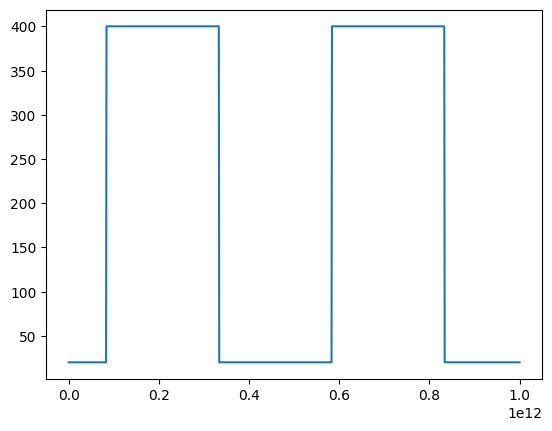

In [21]:
input_excitation = "PULSE1.VAL"
x = tb.post.get_solution_data(input_excitation, "TR", "Time")
plt.plot(x.intrinsics["Time"], x.data_real(input_excitation))

PyAEDT WARNING: No report category provided. Automatically identified Standard


PyAEDT INFO: Solution Data Correctly Loaded.


Time to initialize solution data:0.01816391944885254
Time to initialize solution data:0.01816391944885254


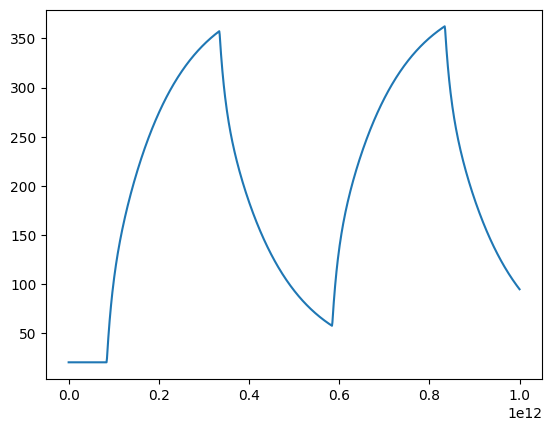

In [22]:
output_temperature = "ROM1.Temperature_history"
x = tb.post.get_solution_data(output_temperature, "TR", "Time")
plt.plot(x.intrinsics["Time"], x.data_real(output_temperature))

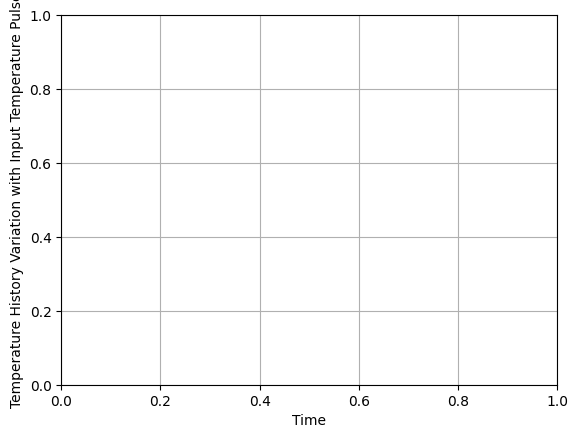

In [23]:
plt.grid()
plt.xlabel("Time")
plt.ylabel("Temperature History Variation with Input Temperature Pulse")
plt.show()

## Close Twin Builder

After the simulation is completed, you can close Twin Builder or release it.
All methods provide for saving the project before closing.

In [24]:
# Clean up the downloaded data.
shutil.rmtree(twin_builder_data_folder)

In [25]:
# Restore the earlier AEDT configuration and schematic environment.
tb._odesktop.SetDesktopConfiguration(current_desktop_config)
tb._odesktop.SetSchematicEnvironment(current_schematic_environment)

## Release AEDT

Release AEDT and close the example.

In [26]:
tb.save_project()
tb.release_desktop()
# Wait 3 seconds to allow AEDT to shut down before cleaning the temporary directory.
time.sleep(3)

PyAEDT INFO: Project dynamic_rom Saved correctly


PyAEDT INFO: Desktop has been released and closed.


## Clean up

All project files are saved in the folder ``temp_folder.name``. If you've run this example as a Jupyter notebook, you
can retrieve those project files. The following cell removes all temporary files, including the project folder.

In [27]:
temp_folder.cleanup()